# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import copy

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print (azdias.shape)

(891221, 85)


In [4]:
azdias.head(3).iloc[:, :20]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0


In [5]:
azdias.head(3).iloc[:, 21:40]

,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ
0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN
1,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0
2,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0


In [6]:
azdias.head(3).iloc[:, 41:60]

,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015
0,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51
2,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24


In [7]:
azdias.head(3).iloc[:, 61:80]

,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0
2,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0


In [8]:
azdias.head(3).iloc[:, 81:]

,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,NaN,NaN,NaN
1,4.0,3.0,5.0,4.0
2,4.0,3.0,5.0,2.0


In [9]:
print ("Total Number of Null Values in azdiaz: ", azdias.isnull().sum().sum())
print ("Percentage in All Values in azdias: ", 
       "{:.2%}".format(azdias.isnull().sum().sum()/azdias.shape[0]/azdias.shape[1]), "\n")


print ("Number of Features having Any Null Values: ", len(np.where(azdias.isnull().sum() > 0)[0]))
print ("Number of Features having All No-Null Values: ", len(np.where(azdias.isnull().sum() == 0)[0]), "\n")

Total Number of Null Values in azdiaz:  4896838
Percentage in All Values in azdias:  6.46% 

Number of Features having Any Null Values:  53
Number of Features having All No-Null Values:  32 



> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

In [11]:
feat_info.set_index("attribute", inplace = True)

In [12]:
(feat_info.index != azdias.columns).sum()

0

In [13]:
feat_info.head(3)

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"


In [14]:
type(feat_info.loc["AGER_TYP", "missing_or_unknown"])

str

In [15]:
feat_info["missing_or_unknown"].value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[XX]         1
[-1,X]       1
[-1,XX]      1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [16]:
feat_info.query('missing_or_unknown == "[-1,XX]"')

,information_level,type,missing_or_unknown
attribute,,,
CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"


In [17]:
azdias["AGER_TYP"].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [18]:
azdias[azdias["CAMEO_INTL_2015"] == "XX"].head(1)[["CAMEO_INTL_2015"]]

,CAMEO_INTL_2015
2511,XX


In [19]:
feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',', expand = True).head()\
.rename(columns = lambda x: "col_" + str(x))

,col_0,col_1,col_2
attribute,,,
AGER_TYP,-1,0,None
ALTERSKATEGORIE_GROB,-1,0,9
ANREDE_KZ,-1,0,None
CJT_GESAMTTYP,0,None,None
FINANZ_MINIMALIST,-1,None,None


In [20]:
missing_df = \
feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',', expand = True)\
.rename(columns = lambda x: "col_" + str(x)).T

In [21]:
missing_df

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
col_0,-1,-1,-1,0,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
col_1,0,0,0,None,None,None,None,None,None,None,...,None,None,None,None,0,None,None,9,0,9
col_2,None,9,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [22]:
for col in missing_df.columns:
    try:
        missing_df[col] = missing_df[col].astype(float)
    except:
        continue

In [23]:
missing_df.T[missing_df.dtypes != "float64"]

,col_0,col_1,col_2
attribute,,,
GFK_URLAUBERTYP,,None,None
GREEN_AVANTGARDE,,None,None
ANZ_PERSONEN,,None,None
ANZ_TITEL,,None,None
ANZ_HH_TITEL,,None,None
KONSUMNAEHE,,None,None
CAMEO_DEUG_2015,-1,X,None
CAMEO_DEU_2015,XX,None,None
CAMEO_INTL_2015,-1,XX,None


In [24]:
for col in azdias.columns:
    try:
        azdias[col] = azdias[col].astype(float)
    except:
        continue

In [25]:
(missing_df.dtypes == 'float64').sum()

72

In [26]:
azdias = azdias.replace(missing_df.to_dict(orient = 'list'), np.nan)

In [27]:
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [28]:
# Perform an assessment of how much missing data there is in each column of the dataset.
table_count_missing_col = azdias.isnull().sum().to_frame("count_missing_col")

# Investigate patterns in the amount of missing data in each column.
table_count_missing_col["pct_missing_col"] = table_count_missing_col["count_missing_col"] / azdias.shape[0] * 100.00

table_count_missing_col.sort_values("pct_missing_col", ascending = False, inplace = True)

In [29]:
(table_count_missing_col["count_missing_col"] > 0).sum()

61

In [30]:
table_count_missing_col.head(10)

,count_missing_col,pct_missing_col
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
KKK,158064,17.735668
REGIOTYP,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG1,133324,14.959701


In [31]:
table_count_missing_col[["pct_missing_col"]].describe().T

,count,mean,std,min,25%,50%,75%,max
pct_missing_col,85.0,11.054139,16.449815,0.0,0.0,10.451729,13.073637,99.757636


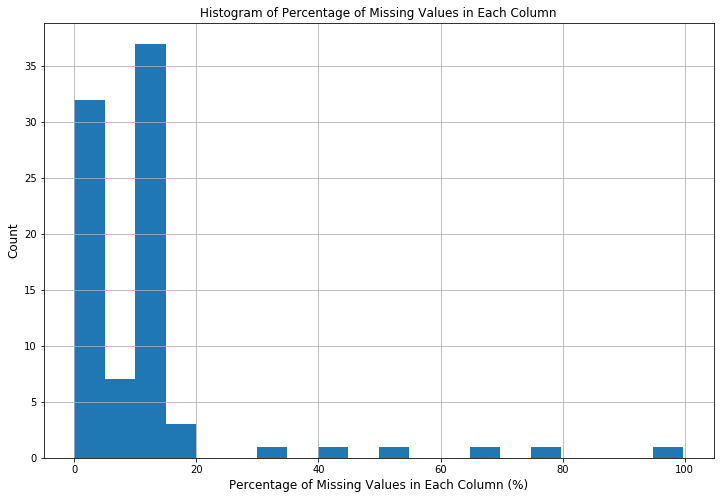

In [32]:
table_count_missing_col.hist("pct_missing_col", bins = 20, figsize = (12,8));
plt.title("Histogram of Percentage of Missing Values in Each Column", fontsize = 12);
plt.xlabel("Percentage of Missing Values in Each Column (%)", fontsize = 12);
plt.ylabel("Count", fontsize = 12);

In [33]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
drop_features = table_count_missing_col[table_count_missing_col["pct_missing_col"] > 20.00].index
drop_features

Index(['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR',
       'ALTER_HH'],
      dtype='object')

In [34]:
azdias.drop(drop_features, axis = 1, inplace = True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

1. After replacing missing or unknown value codes with NaN values, among 85 features, __61__ have missing values. And among all features, `TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, and `ALTER_HH` are top 6 having the highest missing value percentages. 
1. Based on the histogram of missing percentages, most of them are lower than 20%. Therefore, `TITEL_KZ`, `AGER_TYP`, `KK_KUNDENTYP`, `KBA05_BAUMAX`, `GEBURTSJAHR`, and `ALTER_HH` are removed.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [35]:
# How much data is missing in each row of the dataset?
azdias["count_missing_row"] = azdias.isnull().sum(axis = 1)

# Investigate patterns in the amount of missing data in each column.
azdias["pct_missing_row"] = azdias["count_missing_row"] / azdias.shape[1] * 100.00

azdias.sort_values("pct_missing_row", ascending = False, inplace = True)

In [36]:
azdias[["count_missing_row", "pct_missing_row"]].head(10)

,count_missing_row,pct_missing_row
732775,49,61.25
643174,49,61.25
472919,48,60.00
345274,47,58.75
299868,47,58.75
582092,47,58.75
681255,47,58.75
818343,47,58.75
582109,47,58.75
439981,47,58.75


In [37]:
azdias[["pct_missing_row"]].describe().T

,count,mean,std,min,25%,50%,75%,max
pct_missing_row,891221.0,7.062367,16.543358,0.0,0.0,0.0,3.75,61.25


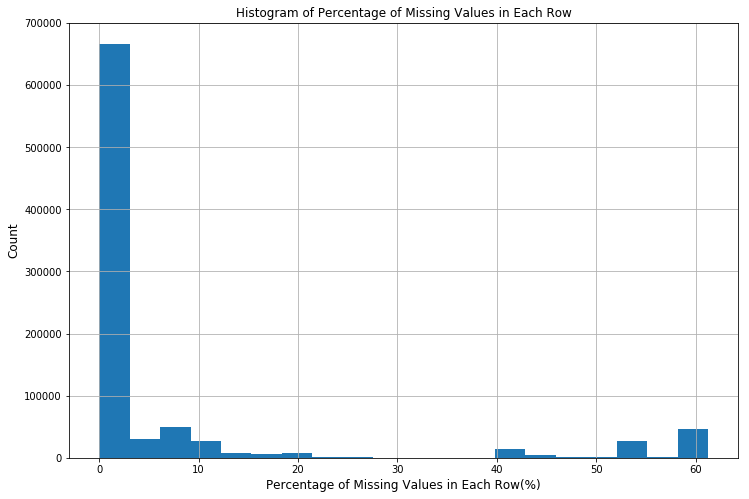

In [38]:
azdias.hist("pct_missing_row", bins = 20, figsize = (12,8));
plt.title("Histogram of Percentage of Missing Values in Each Row", fontsize = 12);
plt.xlabel("Percentage of Missing Values in Each Row(%)", fontsize = 12);
plt.ylabel("Count", fontsize = 12);

In [39]:
1.0 * azdias[azdias["pct_missing_row"] > 10.0].shape[0]/azdias.shape[0]

0.1341081505036349

In [40]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_row_missing_few = azdias[azdias["pct_missing_row"] <= 10.0]
azdias_row_missing_many = azdias[azdias["pct_missing_row"] > 10.0]

In [41]:
print ("Number of Observations with NO More Than 10% Missing Values: ", azdias_row_missing_few.shape[0]) 
print ("Number of Observations with More Than 10% Missing Values: ", azdias_row_missing_many.shape[0])

Number of Observations with NO More Than 10% Missing Values:  771701
Number of Observations with More Than 10% Missing Values:  119520


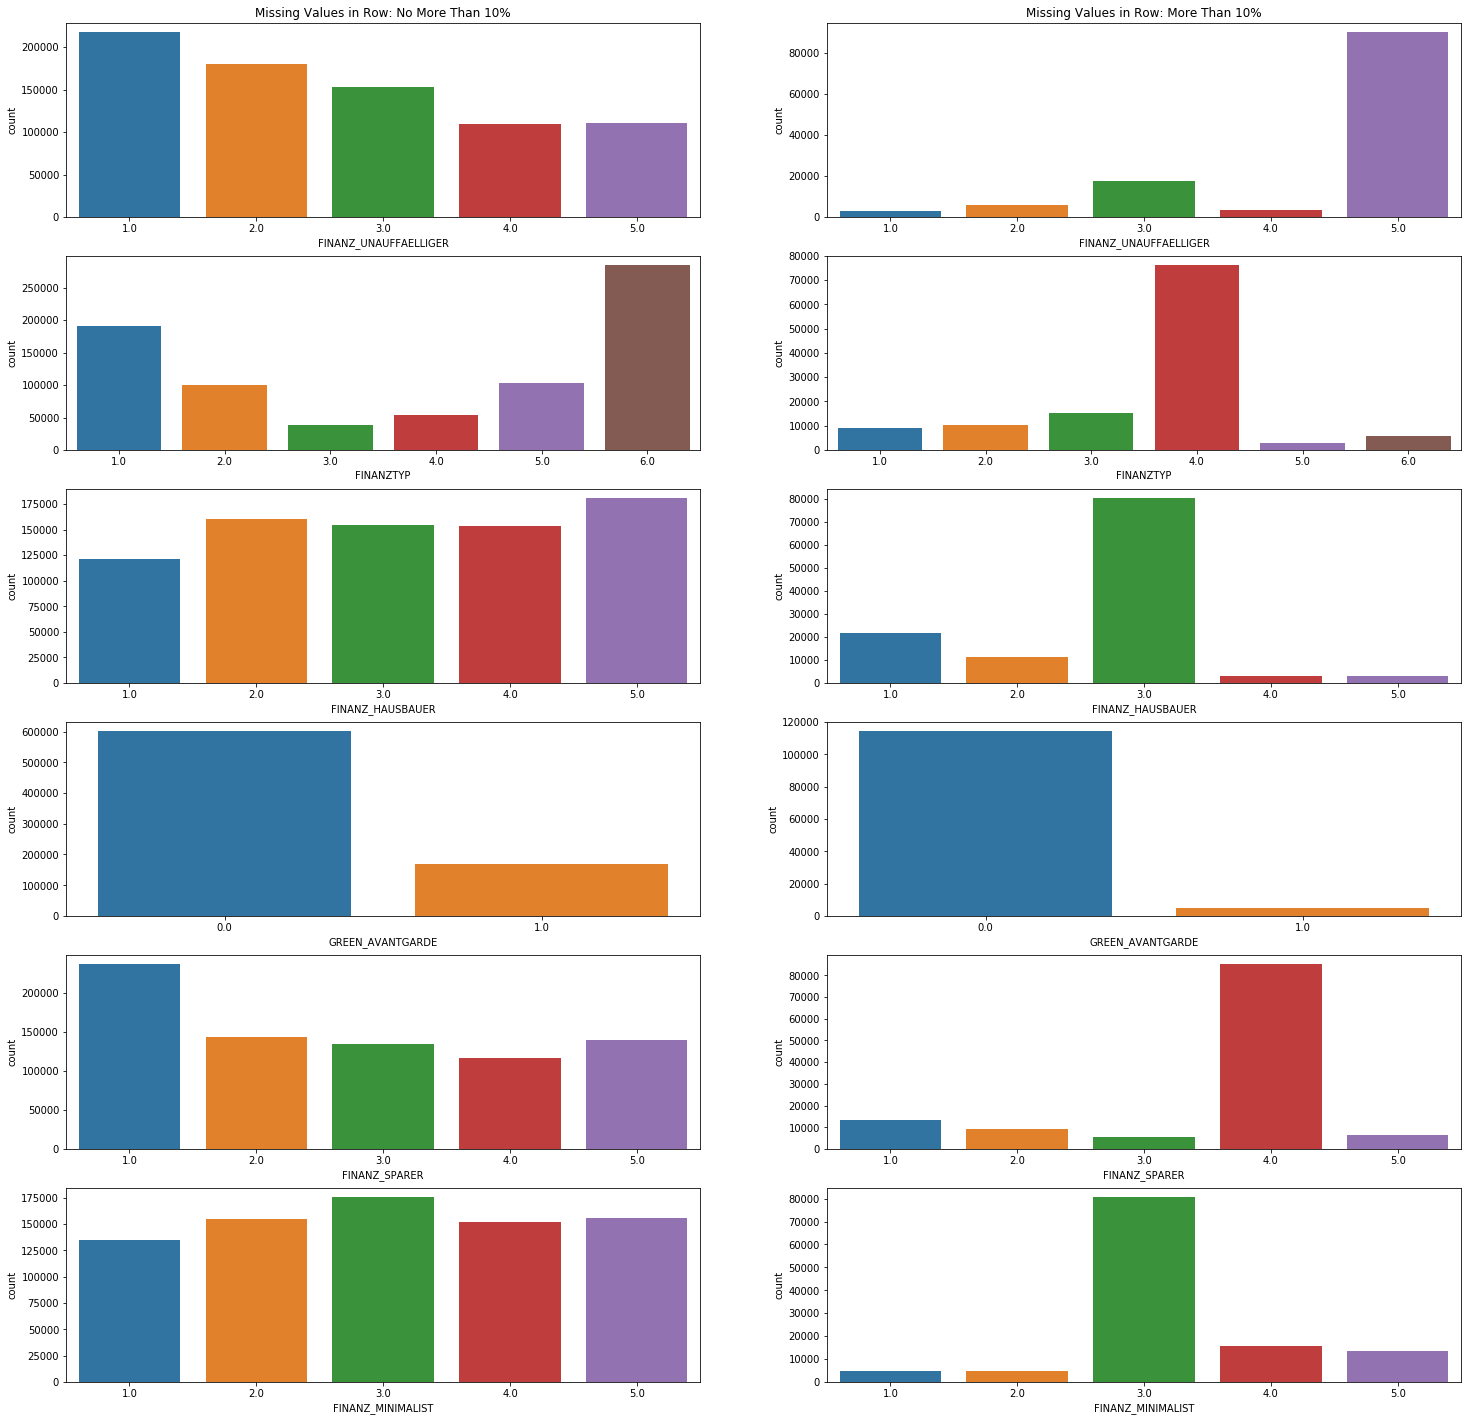

In [42]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
col_checklist = table_count_missing_col.query('count_missing_col == 0').index[:6]

fig, ax = plt.subplots(len(col_checklist), 2, figsize = (25,25))

for k in range(len(col_checklist)):
    sns.countplot(azdias_row_missing_few[col_checklist[k]], ax = ax[k, 0]);
    ax[0, 0].set_title("Missing Values in Row: No More Than 10%");
    
    sns.countplot(azdias_row_missing_many[col_checklist[k]], ax = ax[k, 1]);
    ax[0, 1].set_title("Missing Values in Row: More Than 10%");

In [43]:
# Keep only observations without missing values
azdias = azdias[azdias["pct_missing_row"] <= 10.0].copy(deep = True)

In [44]:
azdias.drop(["count_missing_row", "pct_missing_row"], axis = 1, inplace = True)

In [45]:
azdias.shape

(771701, 79)

In [48]:
col_checklist

Index(['FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'FINANZ_HAUSBAUER',
       'GREEN_AVANTGARDE', 'FINANZ_SPARER', 'FINANZ_MINIMALIST'],
      dtype='object')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


1. Among 891221 observations, at least half of them with 0 missing values, and the maximun percentage of missing value out of 82 features observed for one observation is over 60%.
1. From the bar chart about percentage of missing values in each row, we see that most of them are no more than 10%. And only 13% of our entire data contains more than 10% missing values. Therefore, will split the data based on whether an observation containins more than 10% missing values.
1. Split the entire data set into two subsets based on whether an observation has more than 10% missing values, and compared distributions between these subset of 6 columns which have non-missing values. From the plot above, we should tell they are qualitatively different from each other.
    - `FINANZ_UNAUFFAELLIGER`: 
        - Measures Financial typology about inconspicuous.
        - In data with __More than 10%__ missing values, most frequently observed values are 5 (very low). 
        - In data with __NO More than 10%__ missing values, most frequently observed values are 1 (very high).
    - `FINANZTYP`: 
        - About descriptive financial type for individual.
        - In data with __More than 10%__ missing values, the most frequent value is 4 (be prepared, VORSORGER).
        - In data with __NO More than 10%__ missing values, the most frequent value is 6 (inconspicuous, UNAUFFAELLIGER) and second most frequent value is 1 (low financial interest, MINIMALIST).
     - `FINANZ_HAUSBAUER`: 
        - Measures Financial typology about home ownership.
        - In data with __More than 10%__ missing values, 4 (low) is much more than other categories. 
        - In data with __NO More than 10%__ missing values, the mode is 5 (very low), but 2 (high), 3 (average), 4(low) seem to be equally distributed.
    - `GREEN_AVANTGARDE`: 
        - Tells about Membership in environmental sustainability as part of youth.
        - In data with __More than 10%__ missing values, the mode is 0 (not a member of green avantgarde).  
        - In data with __NO More than 10%__ missing values, the mode is also 0 (not a member of green avantgarde), but the ratio of 1 to 0 (being a member to not being a member) is higher than that from the data containing more than 10% missing values.  
    - `FINANZ_SPARER`: 
        - Tells Financial typology about money-saver. 
        - In data with __More than 10%__ missing values, the mode is 4 (low).  
        - In data with __NO More than 10%__ missing values, the mode is 1 (very high) and 4 (low) is the least frequently observed value.
    - `FINANZ_MINIMALIST`: 
        - Tells Financial typology about low financial interest. 
        - In data with __More than 10%__ missing values, the mode is 3 (average). 
        - In data with __NO More than 10%__ missing values, the mode is also 3 (average), but frequencies of all types are much closer than those from the data containing more than 10% missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [49]:
# How many features are there of each data type?
feat_info["type"].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [50]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

cat_checklist = feat_info[feat_info["type"] == "categorical"].index
cat_var = {"binary":[], "multi_level": []}
for col in azdias.columns:
    if col in cat_checklist:
        if azdias[col].nunique() == 2:
            cat_var["binary"].append([col, azdias[col].unique()])
        elif azdias[col].nunique() > 2:
            cat_var["multi_level"].append([col, azdias[col].unique()])

print ("Dropped Categorical Variables due to Higher Percentage of Mising Values in Each Column: ", "\n", 
      set(cat_checklist) - set(azdias.columns), "\n")            
print ("Binary Variables: {} in total".format(len(cat_var["binary"])), "\n")            
print ("Multi-Level Variables: {} in total".format(len(cat_var["multi_level"])))

Dropped Categorical Variables due to Higher Percentage of Mising Values in Each Column:  
 {'TITEL_KZ', 'KK_KUNDENTYP', 'AGER_TYP'} 

Binary Variables: 5 in total 

Multi-Level Variables: 13 in total


In [51]:
cat_var["binary"]

[['ANREDE_KZ', array([ 2.,  1.])],
 ['GREEN_AVANTGARDE', array([ 0.,  1.])],
 ['SOHO_KZ', array([ 0.,  1.])],
 ['VERS_TYP', array([ nan,   1.,   2.])],
 ['OST_WEST_KZ', array(['W', 'O'], dtype=object)]]

In [52]:
azdias.drop(["FINANZTYP", "LP_FAMILIE_GROB", "LP_STATUS_GROB", "CAMEO_DEUG_2015", "CAMEO_DEU_2015"], 
            axis = 1, inplace = True)

In [53]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias["OST_WEST_KZ"] = azdias["OST_WEST_KZ"].replace("W",1).replace("O",0)

In [54]:
categorial_features_transform = \
["CJT_GESAMTTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN", 
 "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP"]

In [55]:
azdias = pd.get_dummies(azdias, columns = categorial_features_transform)

In [56]:
azdias.shape

(771701, 125)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- There are 21 Categorical Features in original data, and 3 of them got removed because of having too many missing values in their columns.
- Among remaining 18 Categorical Features, 5 of them are Binary Variables and among which `OST_WEST_KZ` takes non-numeric values. And 13 of them are Multi-Level Variables.

Following are Categorical Feature should be re-encoded into dummy variables:
1. Binary: 
    - `OST_WEST_KZ`
1. Multi-Levle: 
    - `CJT_GESAMTTYP`: Customer-Journey-Typology: preferred information and buying channels for
consumer
    - `FINANZTYP`: Most descriptive financial type for individual (low financial interest (MINIMALIST), money-saver (SPARER), home ownership (HAUSBAUER), ...)
    - `GFK_URLAUBERTYP`: Vacation habits (Event travelers, Family-oriented vacationists, Winter sportspeople, ...)
    - `LP_FAMILIE_FEIN`: Family type, fine scale (single, couple, young single parent, single parent with teenager, ...)
    - `LP_FAMILIE_GROB`: Family type, rough scale (single (maps to 1 in fine scale), ...)
    - `LP_STATUS_FEIN`: Social status, fine scale (typical low-income earners, orientation-seeking low-income earners, ...)
    - `LP_STATUS_GROB`: Social status, rough scale (low-income earners (maps to 1-2 in fine scale), ...)
    - `NATIONALITAET_KZ`: Nationality based on given name analysis
    - `SHOPPER_TYP`: Shopper typology (external supplied hedonists, Shopping-stressed, family-shopper, demanding shopper)
    - `ZABEOTYP`: Energy consumption typology (green, smart, fair supplied, price driven, ...)
    - `GEBAEUDETYP`: Type of building (residential vs. commercial) (residential building, residential building buildings without actually known household, ...)
    - `CAMEO_DEUG_2015`: German CAMEO: Wealth / Life Stage Typology, rough scale (upper class, upper middleclass, ...)
    - `CAMEO_DEU_2015`: German CAMEO: Wealth / Life Stage Typology, detailed scale (Work-Life-Balance, Wealthy Best Ager, Successful Songwriter, ...)
    

From Data_Dictionary file, we learned that:
1. `FINANZTYP` can be represented by `FINANZ_MINIMALIST`,`FINANZ_SPARER`,`FINANZ_VORSORGER`,`FINANZ_ANLEGER`,`FINANZ_UNAUFFAELLIGER`,`FINANZ_HAUSBAUER`. Then will remove it.
1. `LP_FAMILIE_FEIN` and `LP_FAMILIE_GROB`, `LP_STATUS_FEIN` and `LP_STATUS_GROB`, `CAMEO_DEUG_2015` and `CAMEO_DEU_2015` contain overlapped information, then only the fine scale features will be kept. In the meantime, there is a feature `CAMEO_INTL_2015` representing "Wealth / Life Stage Typology, mapped to international code" which is similar to `CAMEO_DEUG_2015` and `CAMEO_DEU_2015`, then will remove `CAMEO_DEUG_2015` and `CAMEO_DEU_2015`.


Hence, following are Categorical Feature decided to be re-encoded into dummy variables:
1. Binary: 
    - OST_WEST_KZ
1. Multi-Levle:
    - CJT_GESAMTTYP
    - GFK_URLAUBERTYP
    - LP_FAMILIE_FEIN
    - LP_STATUS_FEIN  
    - NATIONALITAET_KZ
    - SHOPPER_TYP
    - ZABEOTYP
    - GEBAEUDETYP

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias["PRAEGENDE_JUGENDJAHRE"].value_counts()

14.0    177055
8.0     137517
10.0     83180
5.0      82984
3.0      52645
15.0     40684
11.0     34300
9.0      32901
6.0      25293
12.0     23861
4.0      20175
1.0      19974
2.0       7372
13.0      5497
7.0       3934
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

1.18. PRAEGENDE_JUGENDJAHRE

Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [58]:
dict_decades = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80,
                13: 80, 14: 90, 15: 90}
azdias["PRAEGENDE_JUGENDJAHRE_DECADES"] = azdias["PRAEGENDE_JUGENDJAHRE"]\
.replace(to_replace = dict_decades)

# Avantgarden: 0, Mainstream: 1
dict_movements = {1: "Mainstream", 2: "Avantgarde", 3: "Mainstream", 4: "Avantgarde", 
                  5: "Mainstream", 6: "Avantgarde", 7: "Avantgarde", 8: "Mainstream", 
                  9: "Avantgarde", 10: "Mainstream", 11: "Avantgarde", 12: "Mainstream", 
                  13: "Avantgarde", 14: "Mainstream", 15: "Avantgarde"}
azdias["PRAEGENDE_JUGENDJAHRE_MOVEMENTS"] = azdias["PRAEGENDE_JUGENDJAHRE"]\
.replace(to_replace = dict_movements).replace(to_replace = {"Avantgarde": 0, "Mainstream": 1})

In [59]:
azdias[["PRAEGENDE_JUGENDJAHRE", "PRAEGENDE_JUGENDJAHRE_DECADES", "PRAEGENDE_JUGENDJAHRE_MOVEMENTS"]].head(5)#.info()

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADES,PRAEGENDE_JUGENDJAHRE_MOVEMENTS
76279,NaN,NaN,NaN
493154,14.0,90.0,1.0
361857,NaN,NaN,NaN
108690,12.0,80.0,1.0
52464,NaN,NaN,NaN


In [60]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias["CAMEO_INTL_2015"].value_counts()

51    131800
41     90199
24     88313
14     60741
43     55285
54     44601
25     38401
22     31827
45     25524
13     25348
23     23882
55     23244
52     20207
34     18061
31     17596
15     16587
44     14455
12     12618
35     10100
32     10052
33      9521
Name: CAMEO_INTL_2015, dtype: int64

In [61]:
azdias[["CAMEO_INTL_2015"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771701 entries, 76279 to 891220
Data columns (total 1 columns):
CAMEO_INTL_2015    768362 non-null object
dtypes: object(1)
memory usage: 11.8+ MB


In [62]:
def cameo_intl_2015_wealth(cameo_intl_2015):
    try:
        k = int(cameo_intl_2015)
    except:
        k = np.nan
        
    return k//10

def cameo_intl_2015_life(cameo_intl_2015):
    try:
        k = int(cameo_intl_2015)
    except:
        k = np.nan
        
    return k%10

In [63]:
azdias["CAMEO_INTL_2015_WEALTH"] = azdias["CAMEO_INTL_2015"].apply(cameo_intl_2015_wealth)
azdias["CAMEO_INTL_2015_LIFE"] = azdias["CAMEO_INTL_2015"].apply(cameo_intl_2015_life)

In [65]:
azdias[["CAMEO_INTL_2015", "CAMEO_INTL_2015_WEALTH", "CAMEO_INTL_2015_LIFE"]].drop_duplicates(keep = "first")

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE
76279,51,5.0,1.0
493154,32,3.0,2.0
108690,25,2.0,5.0
148374,13,1.0,3.0
410085,23,2.0,3.0
641619,33,3.0,3.0
79323,14,1.0,4.0
789513,43,4.0,3.0
606173,52,5.0,2.0
212576,44,4.0,4.0


In [66]:
azdias.drop(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015"], axis = 1, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In [67]:
# Other Mixed Type Features
feat_info[feat_info["type"] == "mixed"].index

Index(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_BAUMAX', 'PLZ8_BAUMAX'],
      dtype='object', name='attribute')

In [68]:
mixed_checklist = feat_info[feat_info["type"] == "mixed"].index
dropped_mixed = []

for mixed_feature in mixed_checklist:
    if mixed_feature not in azdias.columns:
        dropped_mixed.append(mixed_feature)
        
print ("Dropped Mixed Features: ", set(dropped_mixed), "\n")   
print ("Remaining Mixed Features: ", set(mixed_checklist)- set(dropped_mixed))

Dropped Mixed Features:  {'CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE', 'KBA05_BAUMAX'} 

Remaining Mixed Features:  {'LP_LEBENSPHASE_GROB', 'PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN', 'WOHNLAGE'}


1. `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB` contain Life Stage information and `LP_LEBENSPHASE_FEIN` is recorded in a fine scale while `LP_LEBENSPHASE_GROB` is in a rough scale. As `CAMEO_INTL_2015` also contains Life Stage information, will remove both `LP_LEBENSPHASE_FEIN` and `LP_LEBENSPHASE_GROB`.
1. `WOHNLAGE` contains information about Neighborhood quality (or rural flag). From dictionary we find that `REGIOTYP` contains Neighborhood typology information and `BALLRAUM` contains information about distance to nearest urban center, which is able to flag rural areas. Therefore `WOHNLAGE` will be removed.
1. `PLZ8_BAUMAX` is about most common building type within the PLZ8 region. Will drop this feature as it can be represented by other features in PLZ8 macro-cell features.

In [69]:
azdias.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "WOHNLAGE", "PLZ8_BAUMAX"], 
            axis = 1, inplace = True)

In [70]:
azdias.shape

(771701, 123)

In [71]:
azdias.to_csv("azdias_cleaned.csv", sep=';', index = False)

In [ ]:
#azdias = pd.read_csv("azdias_cleaned.csv", delimiter = ";")

In [ ]:
#azdias.shape

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [ ]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [122]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    import copy
    df_process = copy.deepcopy(df)
    
    feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter = ";")
    feat_info.set_index("attribute", inplace = True)
    
    missing_df = \
    feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',', expand = True)\
    .rename(columns = lambda x: "col_" + str(x)).T


    for col in missing_df.columns:
        try:
            missing_df[col] = missing_df[col].astype(float)
        except:
            continue


    for col in df_process.columns:
        try:
            df_process[col] = df_process[col].astype(float)
        except:
            continue

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df_process.replace(missing_df.to_dict(orient = 'list'), np.nan, inplace = True)    
      
    # remove selected columns and rows, ...
    ### Romove columns
    drop_features = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 
    'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']
    df_process.drop(drop_features, axis=1, inplace=True)
    ### Remove Rows
    df_process["count_missing_row"] = df_process.isnull().sum(axis = 1)
    df_process["pct_missing_row"] = df_process["count_missing_row"] / df_process.shape[1] * 100.00

    df_process = df_process[df_process["pct_missing_row"] <= 10.0].copy(deep = True)
    df_process.drop(["count_missing_row", "pct_missing_row"], axis = 1, inplace = True)

    # select, re-encode, and engineer column values.
    
    ### Drop No Longer Needed Categorical Features
    drop_categorical_features = ["FINANZTYP", "LP_FAMILIE_GROB", "LP_STATUS_GROB", "CAMEO_DEUG_2015", 
                                 "CAMEO_DEU_2015"]
    df_process.drop(drop_categorical_features, axis = 1, inplace = True)
    ### Re-encoding Binary Features
    df_process["OST_WEST_KZ"] = df_process["OST_WEST_KZ"].replace("W",1).replace("O",0)
    ### Re-encoding Multi-Level Features
    categorial_features_transform = \
    ["CJT_GESAMTTYP", "GFK_URLAUBERTYP", "LP_FAMILIE_FEIN", "LP_STATUS_FEIN", 
    "NATIONALITAET_KZ", "SHOPPER_TYP", "ZABEOTYP", "GEBAEUDETYP"]
    df_process = pd.get_dummies(df_process, columns = categorial_features_transform)

    
    ### Engineer Mixed-Type Feature
    ##### PRAEGENDE_JUGENDJAHRE
    dict_decades = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60,
                    7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80,
                    13: 80, 14: 90, 15: 90}
    df_process["PRAEGENDE_JUGENDJAHRE_DECADES"] = df_process["PRAEGENDE_JUGENDJAHRE"]\
    .replace(to_replace = dict_decades)
    
    # Avantgarden: 0, Mainstream: 1
    dict_movements = {1: "Mainstream", 2: "Avantgarde", 3: "Mainstream", 4: "Avantgarde", 
                      5: "Mainstream", 6: "Avantgarde", 7: "Avantgarde", 8: "Mainstream", 
                      9: "Avantgarde", 10: "Mainstream", 11: "Avantgarde", 12: "Mainstream", 
                      13: "Avantgarde", 14: "Mainstream", 15: "Avantgarde"}
    df_process["PRAEGENDE_JUGENDJAHRE_MOVEMENTS"] = df_process["PRAEGENDE_JUGENDJAHRE"]\
    .replace(to_replace = dict_movements).replace(to_replace = {"Avantgarde": 0, "Mainstream": 1})

    ##### CAMEO_INTL_2015
    def cameo_intl_2015_wealth(cameo_intl_2015):
        try:
            k = int(cameo_intl_2015)
        except:
            k = np.nan
        
        return k//10

    def cameo_intl_2015_life(cameo_intl_2015):
        try:
            k = int(cameo_intl_2015)
        except:
            k = np.nan
        
        return k%10

    df_process["CAMEO_INTL_2015_WEALTH"] = df_process["CAMEO_INTL_2015"].apply(cameo_intl_2015_wealth)
    df_process["CAMEO_INTL_2015_LIFE"] = df_process["CAMEO_INTL_2015"].apply(cameo_intl_2015_life)

    ### Drop Original Columns after Engineering AND Other No-Longer Needed Mixed Type Columns
    drop_mixed_original_features = \
    ["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", "LP_LEBENSPHASE_FEIN", 
    "LP_LEBENSPHASE_GROB", "WOHNLAGE", "PLZ8_BAUMAX"]
    df_process.drop(drop_mixed_original_features, axis = 1, inplace = True)
   
    # Return the cleaned dataframe.
    return df_process

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [75]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.isnull().sum().sum()

487905

We still have over 487905 missing values in our cleaned data set. In this dataset, as numbers are representing different categories of a feature, will use most frequently appeared to replace all missing values.

In [89]:
for col in azdias.columns:
    azdias[col] = azdias[col].fillna(azdias[col].mode()[0])

In [90]:
print ("Number of Missing Values after Imputation: ", azdias.isnull().sum().sum())

Number of Missing Values after Imputation:  0


In [91]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(azdias)

In [92]:
azdias_std_scaled = pd.DataFrame(data = scaler.transform(azdias), columns = azdias.columns)

In [93]:
azdias_std_scaled.head().iloc[: , :5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER
0,0.199826,0.959073,-1.488002,1.539656,-0.317869
1,-0.782389,0.959073,-1.488002,0.866704,-0.317869
2,0.199826,0.959073,-1.488002,0.866704,-1.043931
3,0.199826,0.959073,0.690044,0.193752,-0.317869
4,0.199826,-1.042673,-1.488002,1.539656,-1.043931


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)


1. Missing Values are replaced by the most frequently observed value in each column based on the meaning of values in each cloumn.
1. After replacing missing values, standard scaler was applied to scale each feature to mean 0 and standard deviation 1 one.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [94]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

model_pca = PCA(random_state = 42)
azdias_std_scaled_pca = model_pca.fit_transform(azdias_std_scaled)

In [95]:
azdias_std_scaled_pca

array([[  5.90644695e+00,   6.24835103e-01,  -2.10512767e+00, ...,
         -9.25732556e-15,  -3.78837290e-14,  -1.31150453e-13],
       [ -1.05165661e+00,  -4.98902059e+00,  -3.94925952e+00, ...,
          3.50871472e-14,   1.24017118e-13,  -1.44985845e-14],
       [  7.24546511e+00,   1.48479743e+00,  -1.68319205e+00, ...,
          6.48959015e-15,  -5.22861617e-14,   1.70705083e-13],
       ..., 
       [  9.56652944e-01,  -2.43477999e+00,   3.33005213e+00, ...,
         -1.38639343e-16,   1.38542947e-16,   5.00317480e-17],
       [  6.23862382e+00,  -2.93584359e+00,   2.83413381e+00, ...,
         -5.68181929e-17,   1.86721595e-16,   1.41082505e-16],
       [ -1.72085463e-01,   2.15132895e+00,   2.66173530e+00, ...,
          4.81573990e-16,  -3.92475352e-16,  -1.86704208e-17]])

In [96]:
# Scree_Plot function is defined based on Udacity DSND Cource Resource
def scree_plot(pca, figsize):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=figsize)
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component", fontsize = 18)
    ax.set_ylabel("Variance Explained (%)", fontsize = 18)
    ax.set_xticks(np.arange(0, num_components, 10));
    ax.set_xticklabels(np.arange(0, num_components, 10), fontsize = 18, minor = False);
    #ax.set_yticklabels(fontsize = 18);
    plt.title('Explained Variance Per Principal Component', fontsize = 18)

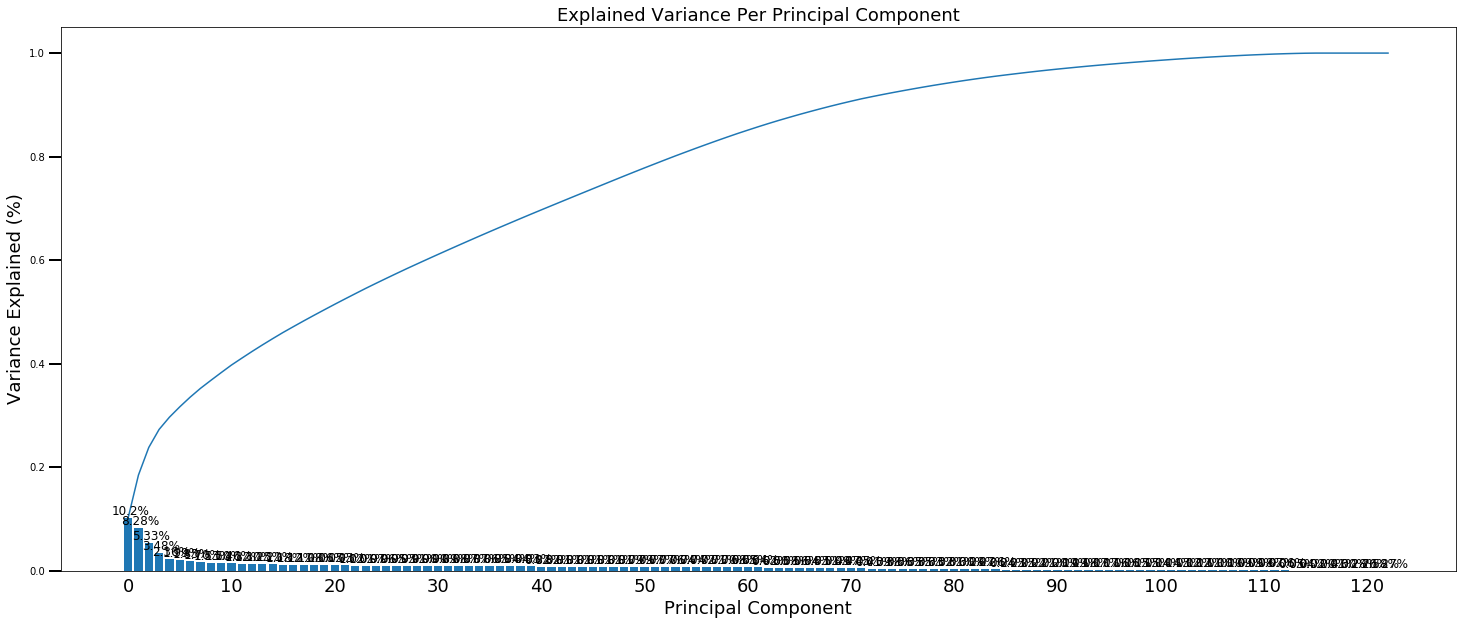

In [97]:
# Investigate the variance accounted for by each principal component.
scree_plot(model_pca, figsize = (25,10))

In [98]:
for k in range(len(model_pca.explained_variance_ratio_)):
    if model_pca.explained_variance_ratio_[:k].sum() >= 0.8:
        print ("The minimum number of components explains at least 80%: ", k)
        break

The minimum number of components explains at least 80%:  54


In [99]:
model_pca.explained_variance_ratio_[0:10]

array([ 0.10203265,  0.08284386,  0.05336112,  0.03482679,  0.02363605,
        0.01997897,  0.01858735,  0.01704533,  0.01532586,  0.01500453])

In [100]:
model_pca.explained_variance_ratio_[50:60]

array([ 0.00792391,  0.00779405,  0.00776715,  0.00767614,  0.0074532 ,
        0.00741484,  0.00724418,  0.00715235,  0.00700118,  0.00686746])

In [101]:
# Re-apply PCA to the data while selecting for number of components to retain.
model_pca_fin = PCA(n_components = 54, random_state = 42)
azdias_std_scaled_pca = model_pca_fin.fit_transform(azdias_std_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


1. Based on PCA model, the first component only explains ~10% of the varaince and the we need at least 54 components to explain at least 80% of variances. And this is less than half of our original feastures. All these 54 components will be retained for the next step of the analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [102]:
def mapping_pca_weights(df, pca_model, dimension):
    index = df.columns
    return pd.DataFrame(data = pca_model.components_[dimension-1], 
                        index = index, 
                        columns = ["dimension_{}_weight".format(dimension)])\
    .sort_values("dimension_{}_weight".format(dimension), ascending = False)

In [103]:
def plot_high_value_weights(df_weights, top_k):
    dimension = df_weights.columns[0].split("_")[1]
    df_weights.head(top_k).append(df_weights.tail(top_k)).plot(kind = "bar", figsize = (25,10));
    plt.title("Top {0} Positive and Negative Components Weights in Dimension {1}".format(top_k , dimension), 
              fontsize = 18);
    plt.xticks(fontsize = 18);
    plt.yticks(fontsize = 18);

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

In [107]:
# Functions is from https://github.com/epmoyer/ipy_table/issues/24
from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [112]:
model_pca_fin.explained_variance_ratio_[0:10]

array([ 0.10203265,  0.08284386,  0.05336112,  0.03482678,  0.02363604,
        0.01997882,  0.01858714,  0.01704486,  0.01532444,  0.0150037 ])

In [108]:
left = pca_1.head(5).append(pca_1.tail(5))
middle = pca_2.head(5).append(pca_2.tail(5))
right = pca_3.head(5).append(pca_3.tail(5))

multi_table([left, middle, right])

,dimension_1_weight
PLZ8_ANTG3,0.196086
HH_EINKOMMEN_SCORE,0.192727
PLZ8_ANTG4,0.189818
CAMEO_INTL_2015_WEALTH,0.184284
ORTSGR_KLS9,0.169109
KBA05_GBZ,-0.193719
PLZ8_ANTG1,-0.196693
KBA05_ANTG1,-0.196961
MOBI_REGIO,-0.207361
FINANZ_MINIMALIST,-0.216399


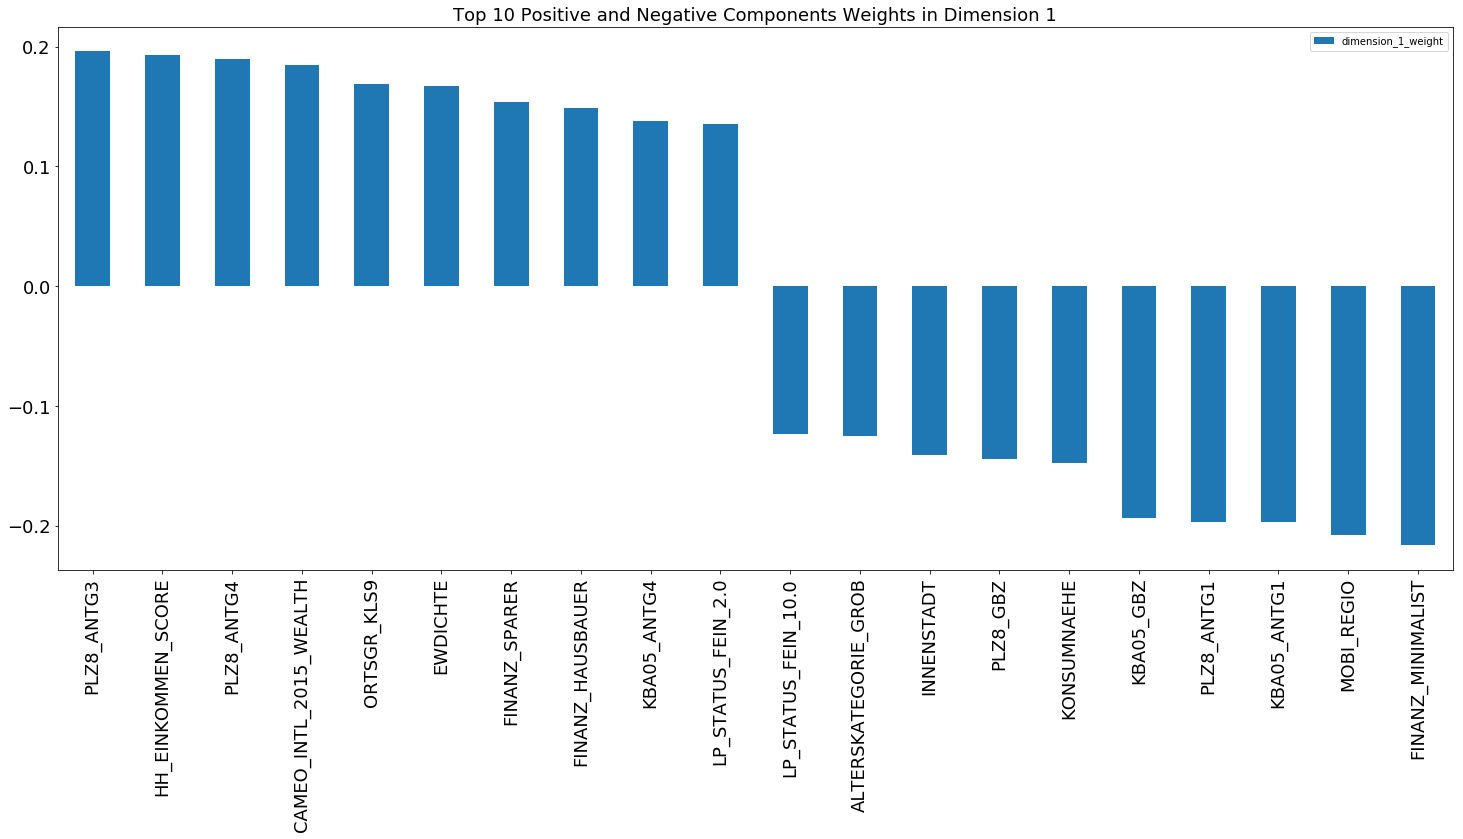

In [109]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_1 = mapping_pca_weights(azdias_std_scaled, model_pca_fin,1)
plot_high_value_weights(pca_1, 10)

__Dimension 1:__

__*Top 5 Positive (Absolute Value from HIGH to LOW):*__
1. PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
1. HH_EINKOMMEN_SCORE: Estimated household net income
1. PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
1. CAMEO_INTL_2015_WEALTH: German CAMEO: Wealth / Life Stage Typology
1. ORTSGR_KLS9: Size of community


__*Top 5 Negative (Absolute Value from LOW to HIGH):*__
1. KBA05_GBZ: Number of buildings in the microcell
1. PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region
1. KBA05_ANTG1: Number of 1-2 family houses in the microcell
1. MOBI_REGIO: Movement patterns
1. FINANZ_MINIMALIST: Financial typology, MINIMALIST: low financial interest


In dimension 1, high weights components are more about communities features.

In more details:
1. PC1 has an eigenvalue of 0.1020
1. FINANZ_MINIMALIST has the greastest impact in PC1 and followed by MOBI_REGIO.
1. PLZ8_ANTG3, and PLZ8_ANTG4 are contrast with PLZ8_ANTG1.

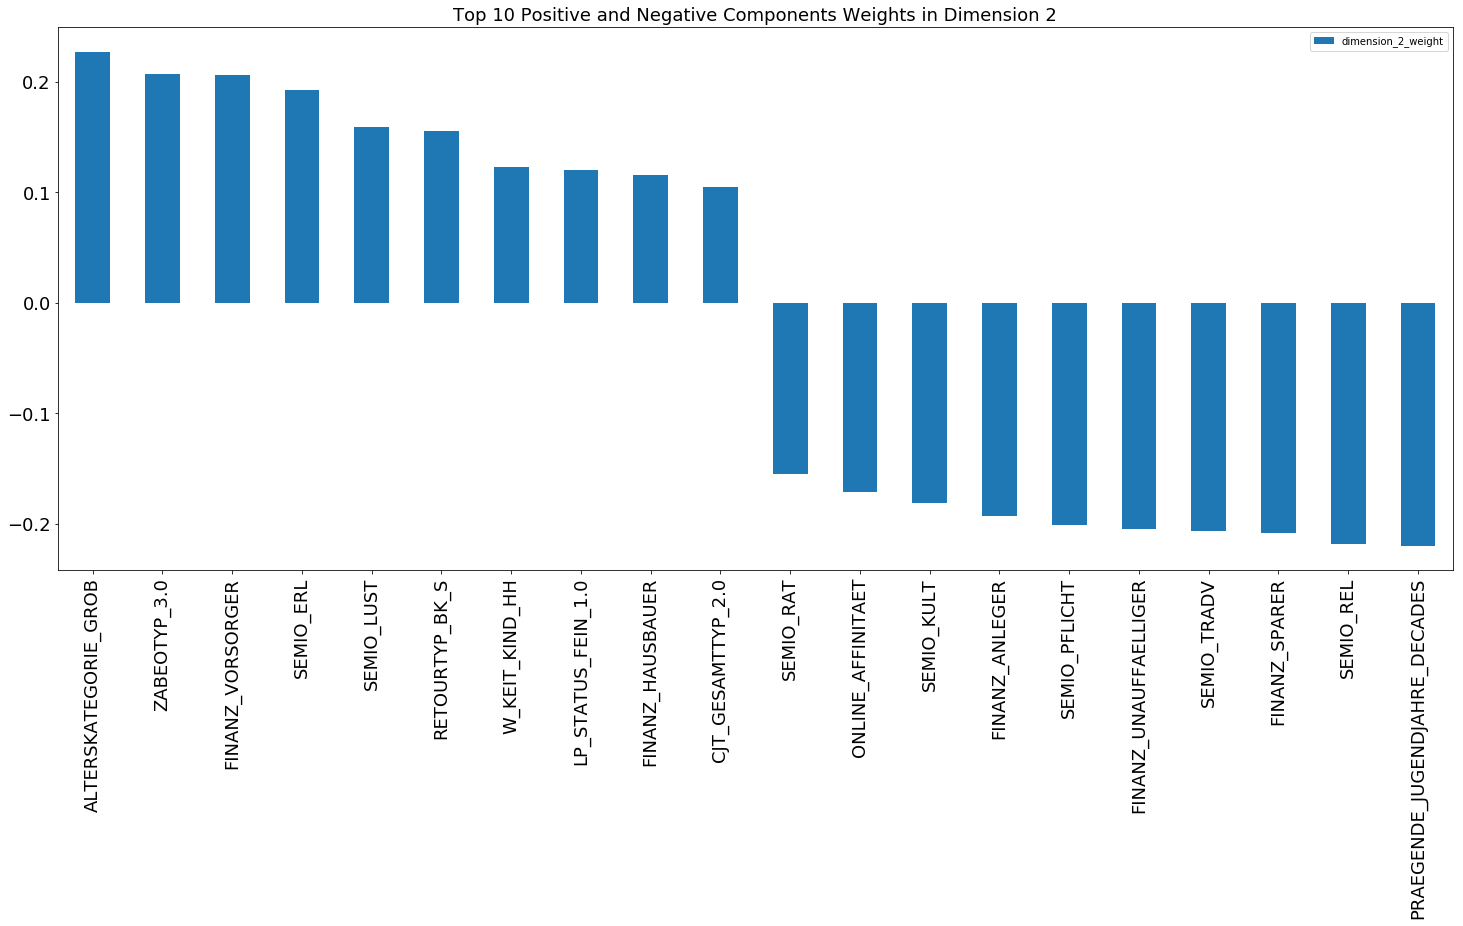

In [110]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_2 = mapping_pca_weights(azdias_std_scaled, model_pca_fin, 2)
plot_high_value_weights(pca_2, 10)

__Dimension 2:__

__*Top 5 Positive (Absolute Value from HIGH to LOW):*__
1. ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
1. ZABEOTYP_3: Energy consumption typology - 3: fair supplied
1. FINANZ_VORSORGER: Financial typology, VORSORGER: be prepared
1. SEMIO_ERL: Personality typology, ERL: event-oriented
1. SEMIO_LUST: Personality typology, LUST: sensual-minded


__*Top 5 Negative (Absolute Value from LOW to HIGH):*__
1. FINANZ_UNAUFFAELLIGER: Financial typology, UNAUFFAELLIGER: inconspicuous
1. SEMIO_TRADV: Personality typology, TRADV: tradional-minded
1. FINANZ_SPARER: Financial typology, SPARER: money-saver
1. SEMIO_REL: Personality typology, REL: religious 
1. PRAEGENDE_JUGENDJAHRE_DECADES: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

In dimension 2, high weights components are more related to Financial and Personality features.

With details:
1. PC2 has an eigenvalue of 0.0828
1. ALTERSKATEGORIE_GROB is the greatest one in this PC and followed by PRAEGENDE_JUGENDJAHRE_DECADES and SEMIO_REL.
1. There is a contrast between FINANZ_VORSORGER and FINANZ_SPARER.

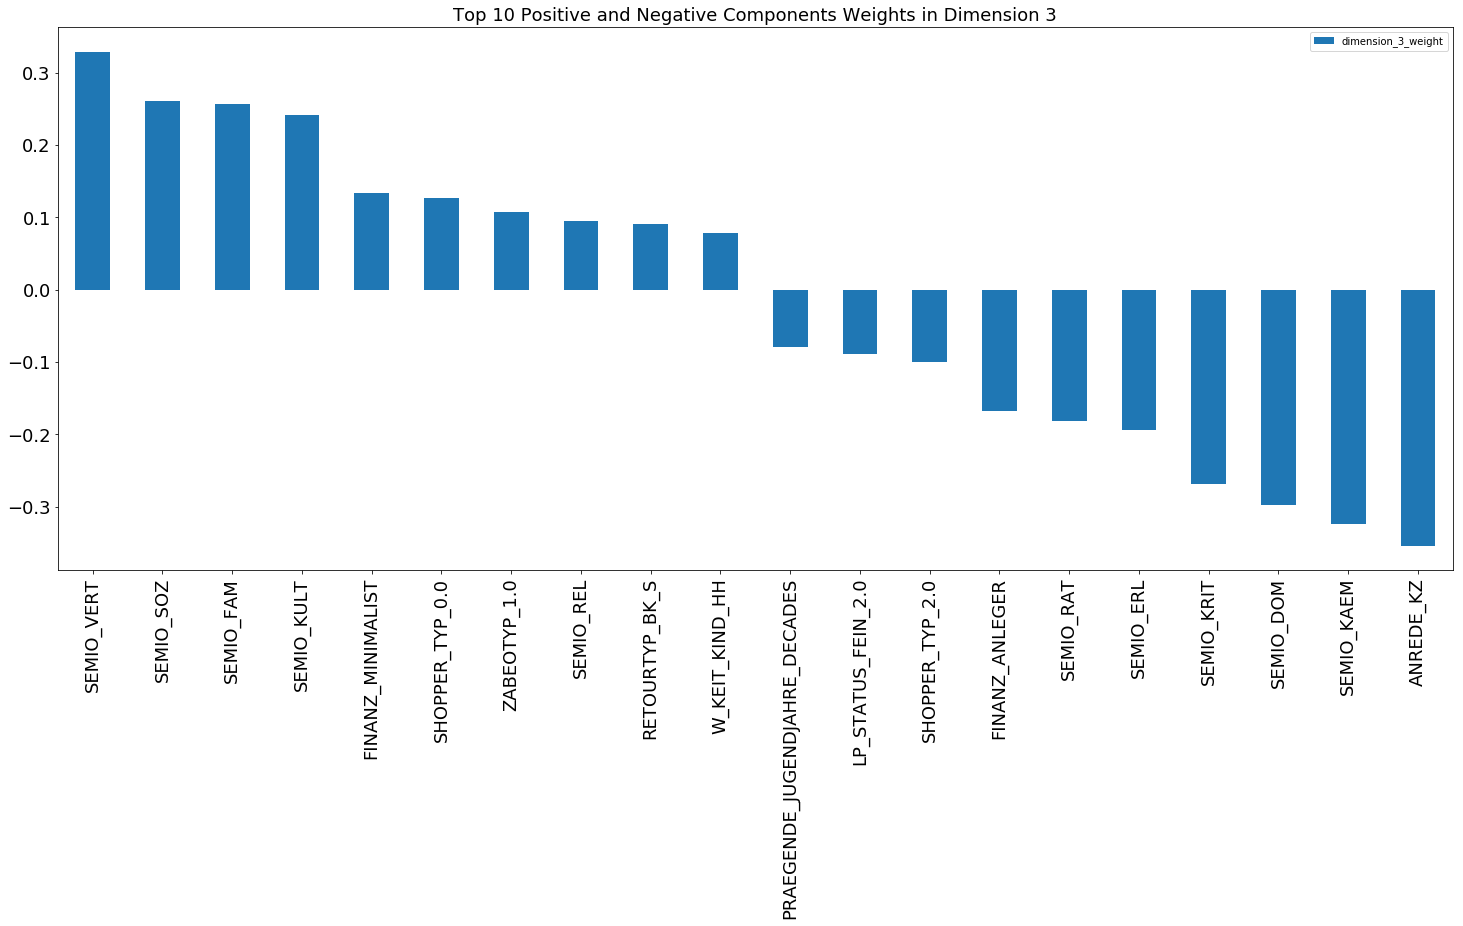

In [111]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_3 = mapping_pca_weights(azdias_std_scaled, model_pca_fin, 3)
plot_high_value_weights(pca_3, 10)

__Dimension 3:__

__*Top 5 Positive (Absolute Value from HIGH to LOW):*__
1. SEMIO_VERT: Personality typology, VERT: dreamful
1. SEMIO_SOZ: Personality typology, socially-minded
1. SEMIO_FAM: Personality typology, family-minded
1. SEMIO_KULT: Personality typology, cultural-minded
1. FINANZ_MINIMALIST: Financial typology, MINIMALIST: low financial interest

__*Top 5 Negative (Absolute Value from LOW to HIGH):*__
1. SEMIO_ERL: Personality typology, event-oriented
1. SEMIO_KRIT: Personality typology, critical-minded
1. SEMIO_DOM: Personality typology, dominant-minded
1. SEMIO_KAEM: Personality typology, combative attitude
1. ANREDE_KZ: Gender

In dimension 3, high weights components are still focused on and more on Personality features.

In PC3:
1. eigenvalue is 0.0534
1. ANREDE_KZ plays a greatest role in this PC and followed by SEMIO_VERT and SEMIO_KAEM.
1. There is a good contrast between SEMIO_VERT and SEMIO_KAEM.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [114]:
def kmeans_scores(df, centers):
# Over a number of different cluster counts...
    from sklearn.cluster import KMeans
    
    model_kmeans_scores = {}

    for center in centers:
        # run k-means clustering on the data and...
        model_kmeans = KMeans(n_clusters = center, random_state = 42).fit(df)
        # compute the average within-cluster distances.
        new_score = np.abs(model_kmeans.score(df))
        
        model_kmeans_scores[center] = new_score
        
    return pd.DataFrame(model_kmeans_scores, index = ["score"]).T

In [115]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
centers = [2,4,8,10,12,14,16,18,20,22,24,26,28,30]

scores = kmeans_scores(azdias_std_scaled_pca, centers)

In [116]:
multi_table([scores[:7],scores[7:]])

,score
2,6.863968e+07
4,6.220903e+07
8,5.696611e+07
10,5.560974e+07
12,5.428232e+07
14,5.346645e+07
16,5.236420e+07
,score
18,5.149866e+07
20,5.024680e+07


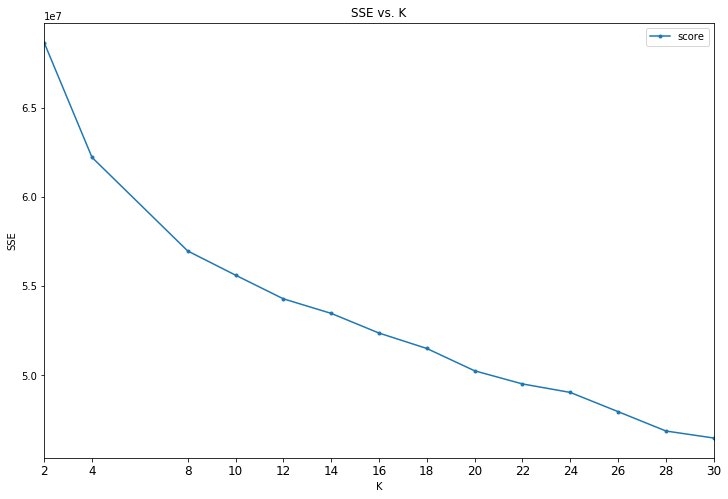

In [117]:
scores.plot(kind = "line", marker = ".", figsize = (12,8));
plt.xlabel('K');
plt.xticks(scores.index, scores.index, fontsize = 12);
plt.ylabel('SSE');
plt.title('SSE vs. K');

The Score tends to be flat when k becomes greater than 16, therefore, will use 16 as our final number of centers.

In [118]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
model_kmeans_fin = KMeans(n_clusters = 16, random_state = 42).fit(azdias_std_scaled_pca)

In [119]:
model_kmeans_fin_pred_general = model_kmeans_fin.predict(azdias_std_scaled_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)


From the plot, we can see that the marginal decrease is getting smaller after 16 clusters. Therefore, will do 16 as our total clusters for our population.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [123]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";")

In [124]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers = clean_data(customers)

In [125]:
# Check Columns between General and Customers Data
set(azdias_std_scaled.columns) - set(customers.columns)

{'GEBAEUDETYP_5.0'}

In [126]:
customers["GEBAEUDETYP_5.0"] = 0

In [127]:
customers.shape

(135799, 123)

In [128]:
customers.isnull().sum().sum()

62683

In [129]:
for col in customers.columns:
    customers[col] = customers[col].fillna(customers[col].mode()[0])

In [130]:
print ("Number of Missing Values after Imputation: ", customers.isnull().sum().sum())    

Number of Missing Values after Imputation:  0


In [131]:
# StandardScaler Customers Data
customers_std_scaled = pd.DataFrame(data = scaler.transform(customers), columns = customers.columns)

In [132]:
# Reduce Dimensions with PCA
customers_std_scaled_pca = model_pca_fin.transform(customers_std_scaled)

In [133]:
# Apply Model to Transformed Customers Data
model_kmeans_fin_pred_customers = model_kmeans_fin.predict(customers_std_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

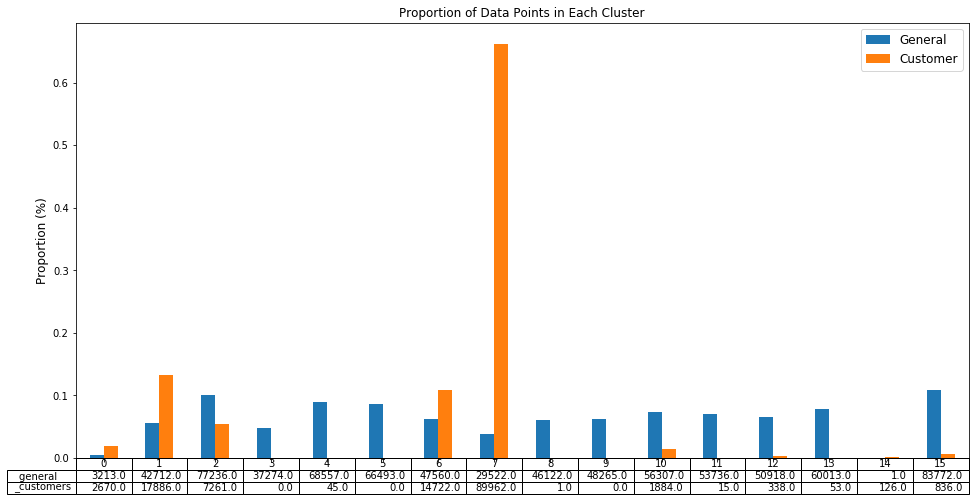

In [135]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
df_pred_cnt = \
pd.concat([pd.DataFrame(data = model_kmeans_fin_pred_general, 
                 columns = ["cluster"])["cluster"].value_counts()\
           .to_frame("cnt_cluster_general").sort_index(ascending = True).fillna(0).T,
           pd.DataFrame(data = model_kmeans_fin_pred_customers, 
                    columns = ["cluster"])["cluster"].value_counts()\
           .to_frame("cnt_cluster_customers").sort_index(ascending = True).T]).fillna(0).T

fig, ax = plt.subplots(1,1,figsize = (16,8))

df_pred_cnt.div(df_pred_cnt.sum(axis = 0), axis = 1)\
.plot(kind = "bar", ax = ax);
ax.set_title("Proportion of Data Points in Each Cluster", fontsize = 12);
ax.set_xticklabels([""], rotation = 0, fontsize = 12);
ax.set_xlabel(" ", fontsize = 12);
ax.set_ylabel("Proportion (%)", fontsize = 12);
ax.legend(["General", "Customer"], fontsize = 12);

from pandas.plotting import table
show_table = table(ax, df_pred_cnt.rename(columns = lambda x: x.replace("cnt_cluster","")).T);

In [137]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

customer_cluster_7 = \
pd.DataFrame(data = model_kmeans_fin_pred_customers, index = customers.index, columns = ["cluster_pred"])\
.merge(customers, how = "outer", left_index = True, right_index = True)\
.query('cluster_pred == 7').drop("cluster_pred", axis = 1)

customer_cluster_7.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,PRAEGENDE_JUGENDJAHRE_DECADES,PRAEGENDE_JUGENDJAHRE_MOVEMENTS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE,GEBAEUDETYP_5.0
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0,0,0,0,0,50.0,0.0,1.0,3.0,0
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,0,0,0,0,1,50.0,0.0,3.0,4.0,0
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,0,0,0,0,0,50.0,0.0,3.0,4.0,0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0,0,0,0,0,50.0,0.0,2.0,3.0,0
7,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0,0,0,0,0,50.0,0.0,1.0,5.0,0


In [145]:
dimension_1_top_bottom_5_features = pca_1.head(3).append(pca_1.tail(3)).index
dimension_2_top_bottom_5_features = pca_2.head(3).append(pca_2.tail(3)).index
dimension_3_top_bottom_5_features = pca_3.head(3).append(pca_3.tail(3)).index

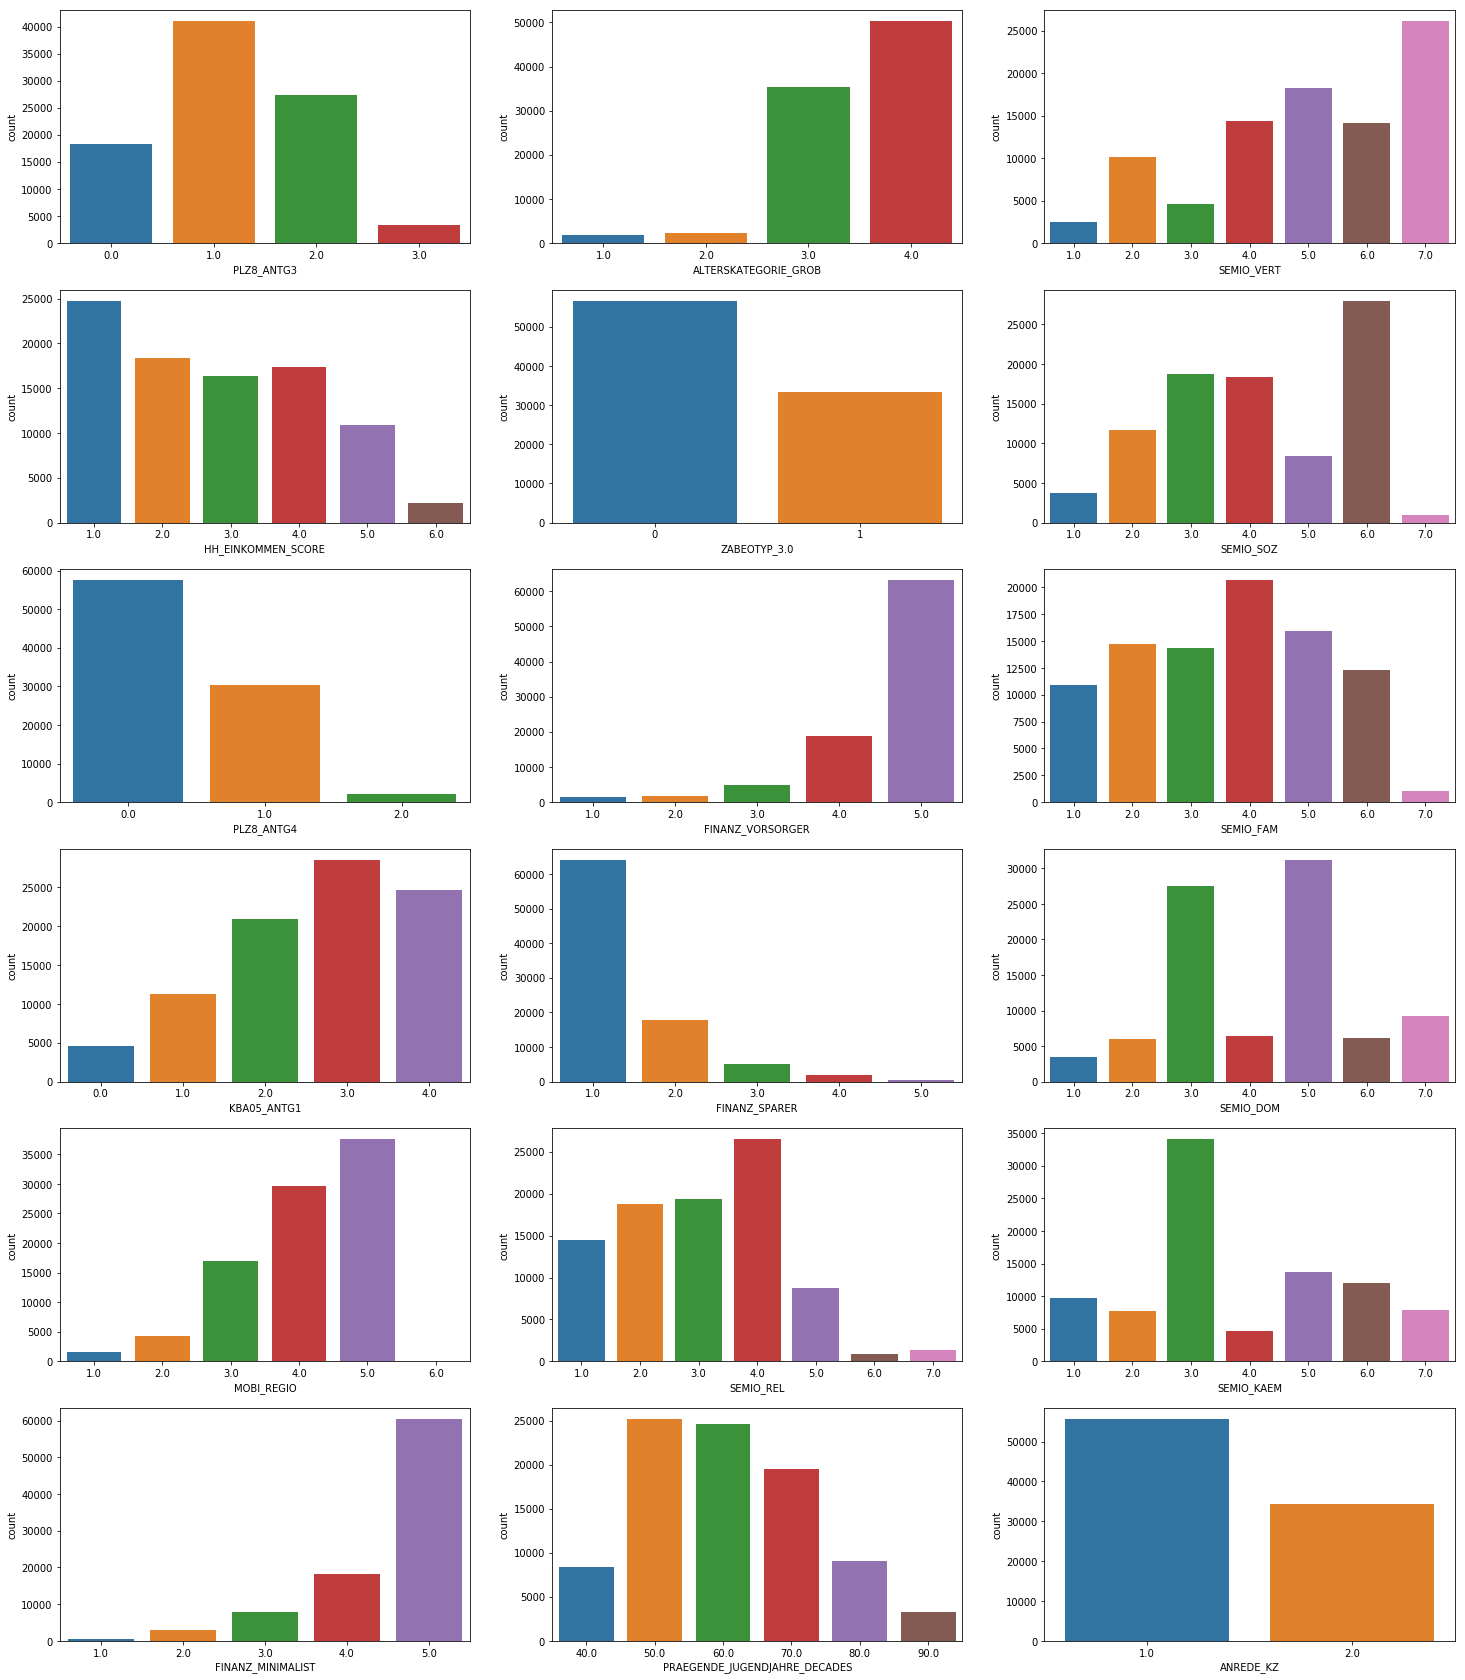

In [148]:
fig, ax = plt.subplots(6,3,figsize = (25,30))

for k in range(len(dimension_1_top_bottom_5_features)):
    ax_row = k // 3
    ax_col = k % 3
    
    sns.countplot(customer_cluster_7[dimension_1_top_bottom_5_features[k]], ax = ax[k, 0]) 
    sns.countplot(customer_cluster_7[dimension_2_top_bottom_5_features[k]], ax = ax[k, 1]) 
    sns.countplot(customer_cluster_7[dimension_3_top_bottom_5_features[k]], ax = ax[k, 2]) 

In Cluster 7 First 3 PCs:
1. Dimension 1 (Top 3 Positive & Top 3 Negative):
    - Positive (Value with Sign from High to Low):
        - PLZ8_ANTG3: mode 1 (lower share of 6-10 family homes)
        - HH_EINKOMMEN_SCORE: mode 1 (highest income)
        - PLZ8_ANTG4: mode 0 (no 10+ family homes)
    - Negative (Value with Sign from High to Low)
        - KBA05_ANTG1: mode 3 (high share of 1-2 family homes)
        - MOBI_REGIO: mode 5 (very low movement)
        - FINANZ_MINIMALIST: MINIMALIST: low financial interest, mode 5 (very low)


2. Dimension 2 (Top 3 Positive & Top 3 Negative)
    - Positive (Value with Sign from High to Low):
        - ALTERSKATEGORIE_GROB: mode 4 (> 60 years old)
        - ZABEOTYP_3: 3: fair supplied, mode 0
        - FINANZ_VORSORGER: VORSORGER: be prepared, mode 5 (very low)
    - Negative (Value with Sign from High to Low):
        - FINANZ_SPARER: SPARER: money-saver, mode 1 (very high)
        - SEMIO_REL: REL: religious, mode 4.0
        - PRAEGENDE_JUGENDJAHRE_DECADES: Dominating movement of person's youth, mode 50, 60


3. Dimension 3 (Top 3 Positive & Top 3 Negative):
    - Positive (Value with Sign from High to Low):
        - SEMIO_VERT: VERT: dreamful, mode 7 (lowest affinity)
        - SEMIO_SOZ: socially-minded, mode 6 (very low affinity)
        - SEMIO_FAM: family-minded, mode 4 (average affinity)
    - Negative (Value with Sign from High to Low):
        - SEMIO_DOM: dominant-minded, mode 5 (low affinity), 3 (high affinity)
        - SEMIO_KAEM: combative attitude, mode 3 (high affinity)
        - ANREDE_KZ: Gender, mode 1 (male)

In [149]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

customer_cluster_15 = \
pd.DataFrame(data = model_kmeans_fin_pred_customers, index = customers.index, columns = ["cluster_pred"])\
.merge(customers, how = "outer", left_index = True, right_index = True)\
.query('cluster_pred == 15').drop("cluster_pred", axis = 1)

customer_cluster_15.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,PRAEGENDE_JUGENDJAHRE_DECADES,PRAEGENDE_JUGENDJAHRE_MOVEMENTS,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE,GEBAEUDETYP_5.0
615,3.0,2.0,1.0,4.0,1.0,4.0,4.0,4.0,0.0,2.0,...,0,0,0,0,1,90.0,1.0,4.0,3.0,0
946,1.0,2.0,1.0,5.0,2.0,5.0,3.0,5.0,0.0,3.0,...,0,0,0,0,0,90.0,1.0,1.0,4.0,0
1466,1.0,2.0,1.0,4.0,1.0,4.0,3.0,4.0,0.0,3.0,...,0,0,0,0,1,90.0,1.0,2.0,4.0,0
1501,1.0,2.0,1.0,4.0,2.0,3.0,3.0,4.0,0.0,3.0,...,0,0,0,0,0,90.0,1.0,5.0,4.0,0
1689,2.0,2.0,1.0,5.0,3.0,5.0,4.0,5.0,0.0,2.0,...,0,0,0,0,1,90.0,1.0,4.0,1.0,0


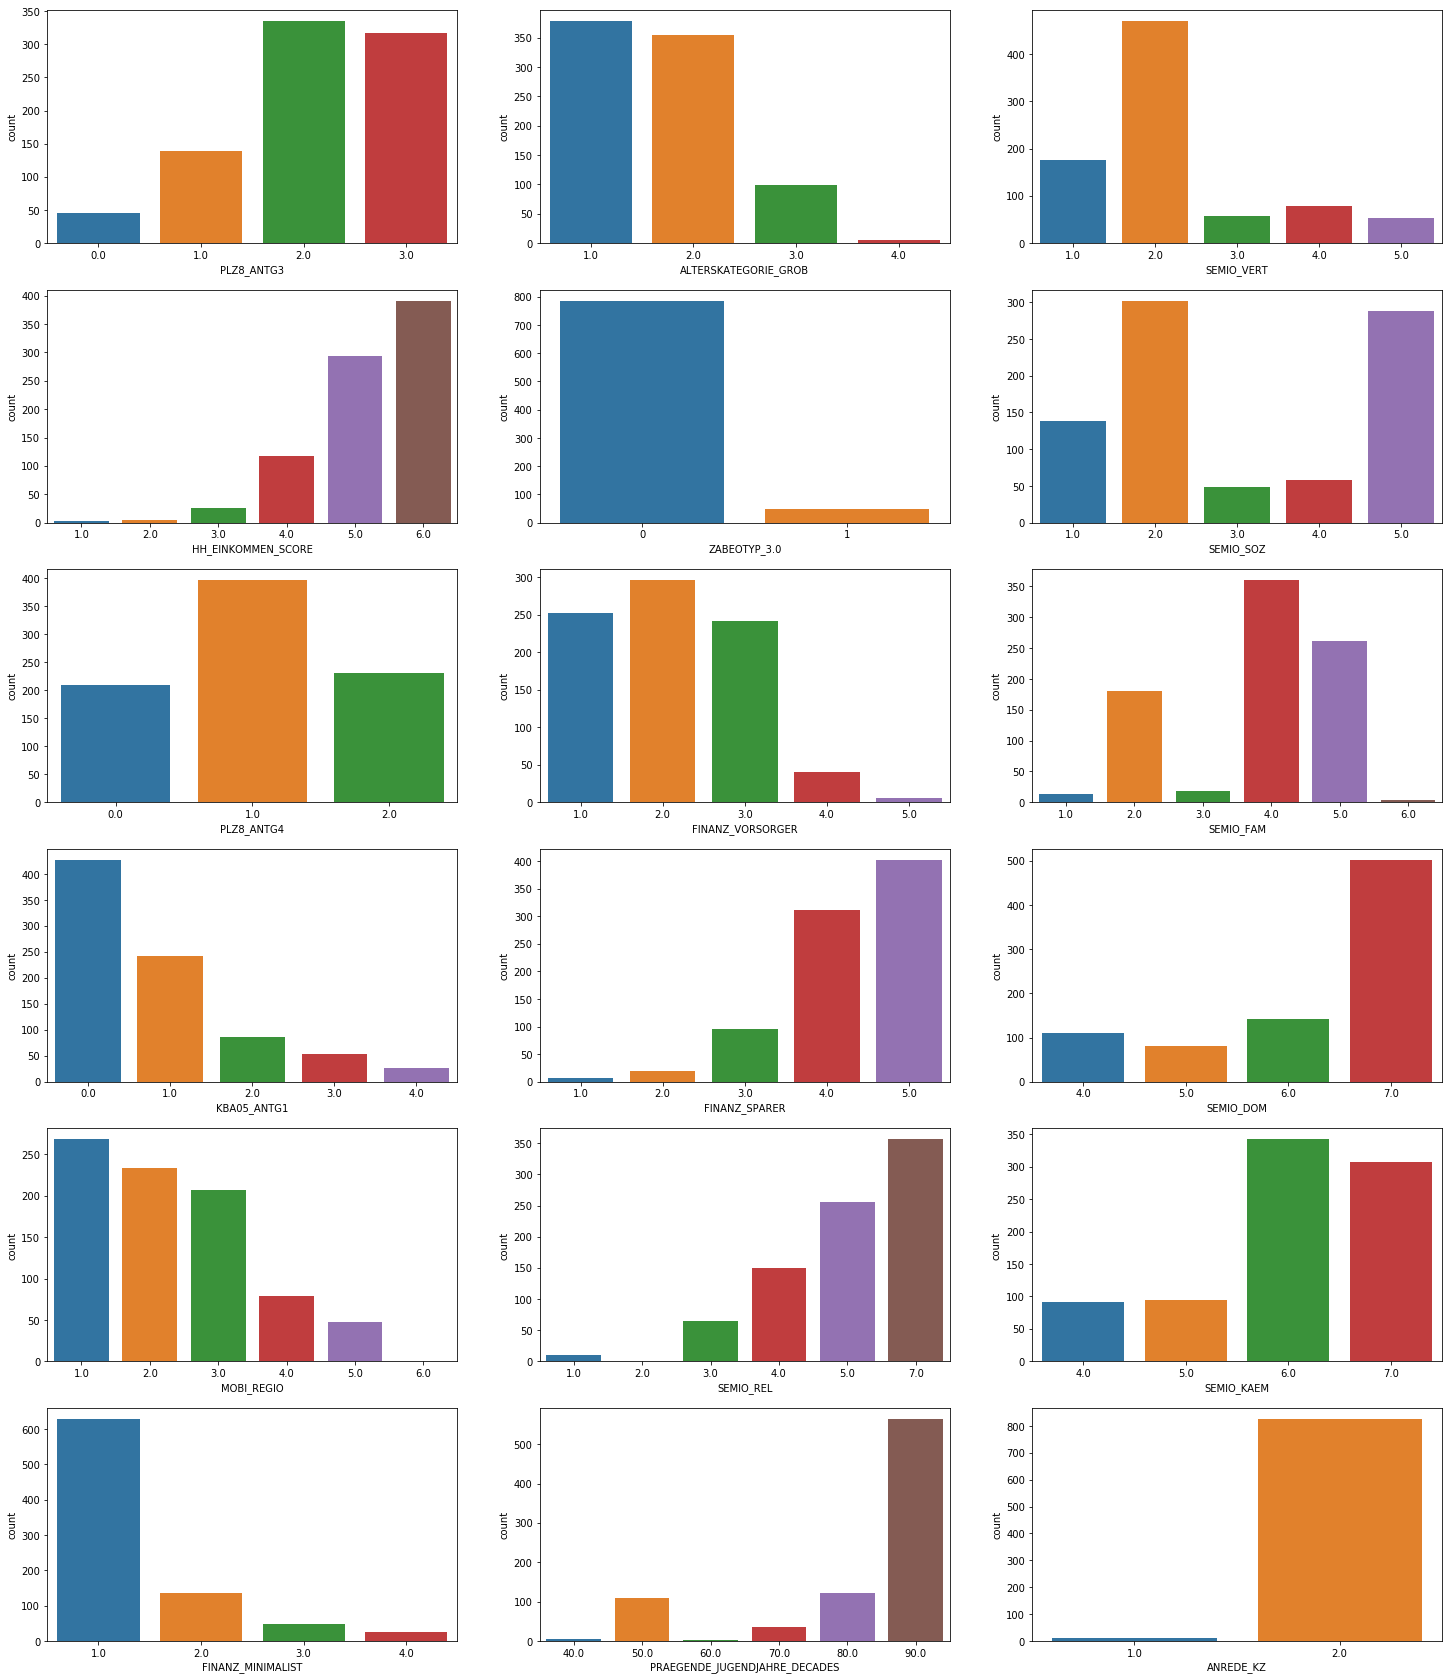

In [150]:
fig, ax = plt.subplots(6,3,figsize = (25,30))

for k in range(len(dimension_1_top_bottom_5_features)):
    ax_row = k // 3
    ax_col = k % 3
    
    sns.countplot(customer_cluster_15[dimension_1_top_bottom_5_features[k]], ax = ax[k, 0]) 
    sns.countplot(customer_cluster_15[dimension_2_top_bottom_5_features[k]], ax = ax[k, 1]) 
    sns.countplot(customer_cluster_15[dimension_3_top_bottom_5_features[k]], ax = ax[k, 2]) 

In Cluster 15 First 3 PCs:
1. Dimension 1 (Top 3 Positive & Top 3 Negative):
    - Positive (Value with Sign from High to Low):
        - PLZ8_ANTG3: mode in 2, 3 (average and high share of 6-10 family homes)
        - HH_EINKOMMEN_SCORE: mode 6 (very low income)
        - PLZ8_ANTG4: mode 1 (lower share of 10+ family homes)
    - Negative (Value with Sign from High to Low):
        - KBA05_ANTG1: mode 0 (no 1-2 family homes)
        - MOBI_REGIO: mode 1 (very high movement)
        - FINANZ_MINIMALIST: MINIMALIST: low financial interest, mode 1 (very high)


2. Dimension 2 (Top 3 Positive & Top 3 Negative)
    - Positive (Value with Sign from High to Low):
        - ALTERSKATEGORIE_GROB: model 1(< 30 years old), 2 (30 - 45 years old)
        - ZABEOTYP_3: 3: fair supplied, mode 0
        - FINANZ_VORSORGER: VORSORGER: be prepared, mode 2 (high)
    - Negative (Value with Sign from High to Low):
        - FINANZ_SPARER: SPARER: money-saver, model 5 (very low)
        - SEMIO_REL: REL: religious, mode 7 (lowest affinity)
        - PRAEGENDE_JUGENDJAHRE_DECADES: Dominating movement of person's youth, mode 90


3. Dimension 3 (Top 3 Positive & Top 3 Negative):
     - Positive (Value with Sign from High to Low):
        - SEMIO_VERT: VERT: dreamful, mode 2 (very high affinity)
        - SEMIO_SOZ: socially-minded, mode 2 (very high affinity), 5 (low affinity)
        - SEMIO_FAM: family-minded, mode 4 (average affinity)
     - Negative (Value with Sign from High to Low):
        - SEMIO_DOM: dominant-minded, mode 7 (lowest affinity)
        - SEMIO_KAEM: combative attitude, mode 6 (very low aaffinity), 7 (lowest affinity)
        - ANREDE_KZ: Gender, mode 2 (female)

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


Cluster 0,1,6,7 are overrepresented in the customer date compared to the general population. And all other clusters are underrepresented.

Based on Cluster 7, we infer the ones popular with male-order company are those who have over average income, live in communities mainly consist of 1-2 family homes, are money-savers and have financial interests but not use to get prepard for financials, moved in 1950s and 1960s and now have very low movements, are over 60 yeard old, and are males.

Based on Cluster 15, we infer the ones unpopular with male-order company are those who have low incomes, live in communities mainly consist of 6-10 family homes, are young (yonger than 45 years old) and still moving, not money savers and have low financial interest, and are females.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.